<a href="https://colab.research.google.com/github/LeonimerMelo/GANs/blob/main/Generate_Realistic_Human_Face_using_GAN_%C2%B7_CelebFaces_Attributes_(CelebA)_Dataset_v11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import os
from matplotlib import pyplot as plt
from tqdm import tqdm
from PIL import Image
from keras import Input
from keras.layers import Dense, Reshape, LeakyReLU, Conv2D, Conv2DTranspose, Flatten, Dropout
from keras.models import Model
from keras.optimizers import RMSprop, Adam
from IPython.display import Image as image
from keras.utils import model_to_dot
from keras.models import load_model
from keras.models import model_from_json
from keras import backend
from IPython import display
import pickle
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PIC_DIR = f'/content/drive/MyDrive/Colab Notebooks/Datasets/img_align_celeba/'
# https://www.kaggle.com/datasets/yunting0123/img-align-celeba/data
#IMAGES_COUNT = 10000
dir = '/content/drive/MyDrive/Colab Notebooks/temp/'
data_pkl = 'dataCelebA128x128.pkl'
# original dimensions of images
ORIG_WIDTH = 178
ORIG_HEIGHT = 218
diff = (ORIG_HEIGHT - ORIG_WIDTH) // 2
# new GAN dimensions
WIDTH = 128
HEIGHT = 128

In [ ]:
try:
  nm_imgs = np.sort(os.listdir(PIC_DIR))
  print('dataset shape:', nm_imgs.shape[0])
except:
  print('dir or file does not exist!')

dir or file does not exist!


In [ ]:
crop_rect = (0, diff, ORIG_WIDTH, ORIG_HEIGHT - diff)
images_ = []
for pic_file in tqdm(nm_imgs):
  try:
    pic = Image.open(PIC_DIR + pic_file).crop(crop_rect)
    pic.thumbnail((WIDTH, HEIGHT), Image.LANCZOS)
    images_.append(np.uint8(pic))
  except:
    print("something went wrong")

100%|██████████| 10000/10000 [05:23<00:00, 30.87it/s]


In [ ]:
# save file X_train to google drive
try:
  output = open(dir + data_pkl, 'wb')
  pickle.dump(images_, output)
  output.close()
  print('file ' + data_pkl + ' saved to drive!')
except:
  print('dir or file does not exist!')

file dataCelebA128x128.pkl saved to drive!


In [ ]:
# load file X_train from google drive
try:
  pkl_file = open(dir + data_pkl, 'rb')
  images_ = pickle.load(pkl_file)
  pkl_file.close()
  print('file ' + data_pkl + ' loaded from drive!')
except:
  print('dir or file does not exist!')

file dataCelebA128x128.pkl loaded from drive!


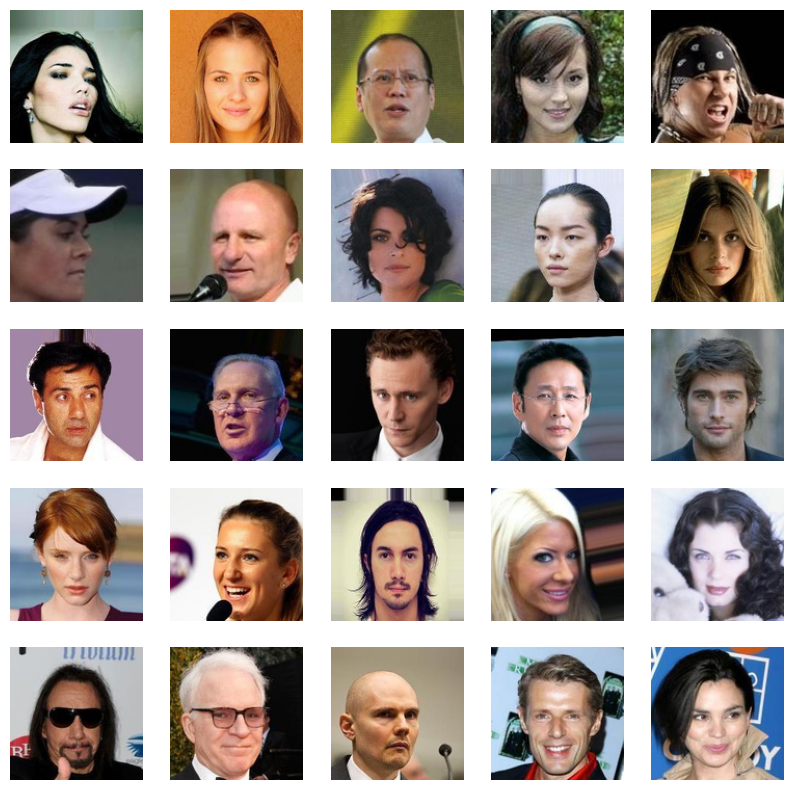

In [ ]:
#Display random 25 images
plt.figure(1, figsize=(10, 10))
j = np.random.randint(len(images_)-25)
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(images_[i+j])
    plt.axis('off')
plt.show()

In [ ]:
images = np.array(images_, dtype=np.dtype(np.float32)) / 255
print('images shape:', images.shape)
print('min:', images.min(), 'max:', images.max())

images shape: (10000, 128, 128, 3)
min: 0.0 max: 1.0


Pixel type: uint8
Number of dimensions: 3
Image size: (128, 128, 3)


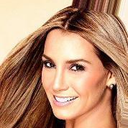

In [ ]:
im = images_[0]
print('Pixel type:', im.dtype)
print('Number of dimensions:', im.ndim)
print('Image size:', im.shape)
pil_img = Image.fromarray(images_[0])
pil_img

In [ ]:
# Resets all state generated by Keras
backend.clear_session()

In [ ]:
LATENT_DIM = 32
CHANNELS = 3

In [ ]:
def create_generator():
    gen_input = Input(shape=(LATENT_DIM, ))

    x = Dense(128 * 16 * 16)(gen_input)
    x = LeakyReLU()(x)
    x = Reshape((16, 16, 128))(x)
    x = Conv2D(256, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(CHANNELS, 7, activation='tanh', padding='same')(x)

    generator = Model(gen_input, x, name='Genarator')
    return generator

In [ ]:
generator = create_generator()
generator.summary()

Model: "Genarator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense (Dense)               (None, 32768)             1081344   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32768)             0         
                                                                 
 reshape (Reshape)           (None, 16, 16, 128)       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 256)       819456    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 32, 32, 256)       10

In [ ]:
def create_discriminator():
    disc_input = Input(shape=(HEIGHT, WIDTH, CHANNELS))

    x = Conv2D(256, 3)(disc_input)
    x = LeakyReLU()(x)
    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)
    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)
    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)
    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)
    x = Flatten()(x)
    x = Dropout(0.4)(x)
    x = Dense(1, activation='sigmoid')(x)
    discriminator = Model(disc_input, x, name='Discriminator')

    optimizer = RMSprop(learning_rate=0.0001, clipvalue=1.0, weight_decay=1e-8)
    discriminator.compile(optimizer=optimizer, loss='binary_crossentropy')

    return discriminator

In [ ]:
discriminator = create_discriminator()
discriminator.trainable = False
discriminator.summary()

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 126, 126, 256)     7168      
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 126, 126, 256)     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 62, 62, 256)       1048832   
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 62, 62, 256)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 30, 30, 256)       1048832   
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 30, 30, 256)     

In [ ]:
gan_input = Input(shape=(LATENT_DIM, ))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output, name='GAN')
optimizer = RMSprop(learning_rate=0.0001, clipvalue=1.0, weight_decay=1e-8)
gan.compile(optimizer=optimizer, loss='binary_crossentropy')
gan.summary()

Model: "GAN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32)]              0         
                                                                 
 Genarator (Functional)      (None, 128, 128, 3)       14953987  
                                                                 
 Discriminator (Functional)  (None, 1)                 4211713   
                                                                 
Total params: 19165700 (73.11 MB)
Trainable params: 14953987 (57.04 MB)
Non-trainable params: 4211713 (16.07 MB)
_________________________________________________________________


In [ ]:
# Rotina para salvar o modelo da rede treinada (modelo, pesos e bias) para predições futuras sem ter que treiná-lo novamente
def model_save(model, name):
  mod = str(name)
  model_json = model.to_json()
  try:
    with open(dir + 'modelCelebA' + mod +'.json','w') as json_file:
        json_file.write(model_json)
    model.save_weights(dir + 'weightsCelebA' + mod + '.h5')
  except:
    print('drive canot be open to save files!')
    return

  print('Saved model ' + mod + ' to disk')

In [ ]:
RES_DIR ='/content/drive/MyDrive/Colab Notebooks/images'
FILE_PATH = '%s/generated_%d.png'
if not os.path.isdir(RES_DIR):
    os.mkdir(RES_DIR)

d_losses = []
a_losses = []

In [ ]:
# train the GAN: generator and discriminator
def train(epochs=200, batch_size=16, start=0):
  CONTROL_SIZE_SQRT = 6
  control_vectors = np.random.normal(size=(CONTROL_SIZE_SQRT**2, LATENT_DIM)) / 2
  images_saved = 0
  for step in range(epochs):
      start_time = time.time()
      latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
      generated = generator.predict(latent_vectors, verbose=0)

      real = images[start:start + batch_size]
      combined_images = np.concatenate([generated, real])

      labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
      labels += .05 * np.random.random(labels.shape)

      d_loss = discriminator.train_on_batch(combined_images, labels)
      d_losses.append(d_loss)

      latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
      misleading_targets = np.zeros((batch_size, 1))

      a_loss = gan.train_on_batch(latent_vectors, misleading_targets)
      a_losses.append(a_loss)

      start += batch_size
      if start > images.shape[0] - batch_size:
          start = 0
      print('.', end='')

      if step % 10 == 0:
          display.clear_output(wait=True)
          print('%d/%d: d_loss: %.4f,  a_loss: %.4f.  (%.1f sec)' % (step + 1, epochs, d_loss, a_loss, time.time() - start_time))
          control_image = np.zeros((WIDTH * CONTROL_SIZE_SQRT, HEIGHT * CONTROL_SIZE_SQRT, CHANNELS))
          control_generated = generator.predict(control_vectors, verbose=0)
          for i in range(CONTROL_SIZE_SQRT ** 2):
              x_off = i % CONTROL_SIZE_SQRT
              y_off = i // CONTROL_SIZE_SQRT
              control_image[x_off * WIDTH:(x_off + 1) * WIDTH, y_off * HEIGHT:(y_off + 1) * HEIGHT, :] = control_generated[i, :, :, :]
          im = Image.fromarray(np.uint8(control_image * 255))
          im.save(FILE_PATH % (RES_DIR, images_saved))
          images_saved += 1
          plt.figure(figsize = (10,10))
          plt.imshow(im)
          plt.axis('off')
          plt.show()

          # save models and weigths
          model_save(generator, 'Generator')
          model_save(discriminator, 'Discriminator')
          model_save(gan, 'GAN')

In [ ]:
# train model
epochs = 150
batch_size = 16
start_pict = 500
train(epochs, batch_size, start_pict)

In [ ]:
plt.figure(1, figsize=(12, 8))
plt.subplot(121)
plt.plot(d_losses, color='red')
plt.xlabel('epochs')
plt.ylabel('discriminant losses')
plt.subplot(122)
plt.plot(a_losses)
plt.xlabel('epochs')
plt.ylabel('adversary losses')
plt.show()

In [ ]:
import imageio.v2
import shutil
images_to_gif = []
for filename in os.listdir(RES_DIR):
    images_to_gif.append(imageio.v2.imread(RES_DIR + '/' + filename))
imageio.mimsave('trainnig_visual.gif', images_to_gif)
shutil.rmtree(RES_DIR)

In [ ]:
# rotina para carregar os modelos das redes treinadas (modelo, pesos e bias)
# para predições futuras sem ter que treiná-lo novamente ou para reiniciar os treinamentos
def load_model(name):
  mod = str(name)
  try:
    # Load json and create model
    j_file = open(dir + 'modelCelebA' + mod +'.json','r')
  except:
    print('file does not exist or drive is not open!')
    return

  load_model_json = j_file.read()
  j_file.close()
  loaded_model=model_from_json(load_model_json)
  try:
    # Load weights into new model
    loaded_model.load_weights(dir + 'weightsCelebA' + mod + '.h5')
  except:
    print('file does not exist or drive is not open!')
    return

  print('Loaded model ' + mod + ' from disk')
  return loaded_model

In [ ]:
# carrego os modelos treinados
generator = load_model('Generator')
discriminator = load_model('Discriminator')
gan = load_model('GAN')

Loaded model Generator from disk
Loaded model Discriminator from disk
Loaded model GAN from disk


In [ ]:
optimizer = RMSprop(learning_rate=0.0001, clipvalue=1.0, weight_decay=1e-8)
discriminator.compile(optimizer=optimizer, loss='binary_crossentropy')
gan.compile(optimizer=optimizer, loss='binary_crossentropy')

In [ ]:
# função para gerar as imagens fake com as pedições
def plot_generated_images(examples=50):
  latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
  generated = generator.predict(latent_vectors, verbose=0)



  #verificar e modificar
  noise = np.random.normal(0, 1, size=[examples, LATENT_DIM])
  generated_images = gan.predict(noise, verbose='None')
  discr_predict = discriminator.predict(generated_images, verbose='None')
  #gen_images = generated_images.reshape(examples, 32, 32, 3)
  gen_images = generated_images.reshape(examples, 64, 64, 3)
  # scale from [-1,1] to [0,1]
  gen_images = (gen_images + 1) / 2.0
  dim=(10, 10)
  plt.figure(figsize=(13, 15))
  for i in range(gen_images.shape[0]):
    plt.subplot(dim[0], dim[1], i+1)
    plt.imshow(gen_images[i])
    a=discr_predict[i][0]
    fo = "{:.2f}".format(a)
    plt.title(str(fo), size=10)
    plt.axis('off')
  #plt.tight_layout()

In [ ]:
# # função para plotar as imagens reais com as pedições
def plot_real_images(examples=50):
  X_real = images[0:examples]
  #X_real, _ = generate_real_samples(dataset, examples)
  discr_predict = discriminator.predict(X_real, verbose='None')
  # scale from [-1,1] to [0,1]
  X_real = (X_real + 1) / 2.0
  dim=(10, 10)
  plt.figure(figsize=(13, 15))
  for i in range(X_real.shape[0]):
    plt.subplot(dim[0], dim[1], i+1)
    plt.imshow(X_real[i])
    a=discr_predict[i][0]
    fo = "{:.2f}".format(a)
    plt.title(str(fo), size=10)
    plt.axis('off')
  #plt.tight_layout()

In [ ]:
plot_generated_images()

In [ ]:
plot_real_images()

##Exercícios
1. Treinar a rede com as configurações default e verificar os resultados
1. Modificar o reescalonamento dos pixels da imagem orinal normalizando os dados de entrada entre -1.0 e 1.0. Compare os resultados.
1. Modificar o valor do parâmetro 'LATENT_DIM' para 100 e comparar os resultados.
1. Utilizar o otimizador Adam e comparar os resultados.
1. Modificar o learning rate do RMSProp e do Adam e comparar os resultados.